<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification to detect sensitive data exposure

## Importing libraries and downloading the dataset

In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Downloading the dataset
git_folder = "/content/Detection-of-Sensitive-Data-Exposure-in-Images"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images.git

dataset_folder = git_folder + "/text_dataset/"
sensitive_datafile = "SensitiveDataset.json"
nonsensitive_datafile = "NonSensitiveDataset.json"

In [ ]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

## Preprocessing the dataset

In [ ]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more 
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(dataset_folder + filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])

# Loading both sensitive and non-sensitive dataset
loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)

# Shuffling the dataset randomly
random.shuffle(dataList)

# Dataset size: 31500 (approx)
print("Dataset Size: ", len(dataList))

# Dataset has both sentences and labels
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])

# Splitting up the total dataset
# Training size = 20000
# Validation size = 11500 (approx)
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: In town Cottonwood Springs, Texas turn century, Marshal Frank Patch Old West style lawman community determined modern. When Patch kills drunken Luke Mills self-defense, town decides time marshal resign. But Patch refuses, reminding citizens took job, agreement long wanted. Afraid Patch knowledge misdeeds town's wilder days, city fathers decide way remove Patch office violence.
Patch humiliates one town's councilmen, cowardly shopkeeper, slapping him. The man plans kill Patch, Patch faces down, turns gun himself. The man's son swears revenge, supported local leaders. They plot ambush Patch. Aware will probably killed, Patch marries long-time girlfriend, local brothel madame. The marriage day shopkeeper's funeral, Patch's death planned. The dead man's son attempts kill Patch own, shot Patch. Patch explains dying youth father murdered man many years ago. Patch covered agreed raise dead man's child. Patch pursues one 

In [ ]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 103137
Saving the word index as JSON


In [ ]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## Model

In [ ]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(24, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 60, 32)            96000     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 56, 64)            10304     
_________________________________________________________________
global_average_pooling1d_12  (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 25        
Total params: 107,889
Trainable params: 107,889
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
num_epochs = 6

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/6
625/625 [==============================] - 7s 11ms/step - loss: 0.1671 - accuracy: 0.9821 - val_loss: 0.0035 - val_accuracy: 0.9993
Epoch 2/6
625/625 [==============================] - 7s 11ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 3/6
625/625 [==============================] - 7s 11ms/step - loss: 7.3843e-04 - accuracy: 0.9999 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 4/6
625/625 [==============================] - 7s 11ms/step - loss: 4.8836e-04 - accuracy: 0.9999 - val_loss: 7.8512e-04 - val_accuracy: 0.9998
Epoch 5/6
625/625 [==============================] - 7s 11ms/step - loss: 3.9614e-05 - accuracy: 1.0000 - val_loss: 6.0187e-04 - val_accuracy: 0.9999
Epoch 6/6
625/625 [==============================] - 7s 11ms/step - loss: 3.6823e-04 - accuracy: 0.9999 - val_loss: 4.9978e-04 - val_accuracy: 0.9998


## Plotting Accuracy and Loss Functions

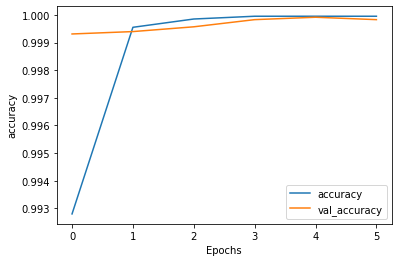

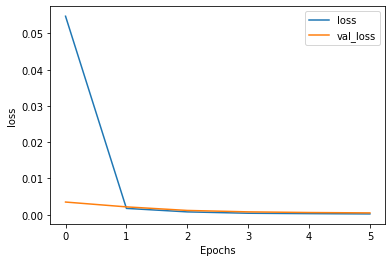

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Saving the model

In [ ]:
# Save and convert the model (Used for deploying in web application)
model.save('model/text_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/text_model.h5 /content/text_model
print("Model converted to JSON successfully")

Saved the model successfully
Selecting previously unselected package python-pip-whl.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../python-pip-whl_9.0.1-2.3~ubuntu1.18.04.4_all.deb ...
Unpacking python-pip-whl (9.0.1-2.3~ubuntu1.18.04.4) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../python3-pkg-resources_39.0.1-2_all.deb ...
Unpacking python3-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python3-virtualenv.
Preparing to unpack .../python3-virtualenv_15.1.0+ds-1.1_all.deb ...
Unpacking python3-virtualenv (15.1.0+ds-1.1) ...
Selecting previously unselected package virtualenv.
Preparing to unpack .../virtualenv_15.1.0+ds-1.1_all.deb ...
Unpacking virtualenv (15.1.0+ds-1.1) ...
Setting up python-pip-whl (9.0.1-2.3~ubuntu1.18.04.4) ...
Setting up python3-pkg-resources (39.0.1-2) ...
Setting up python3-virtualenv (15.1.0+ds-1.1) ...
Setting up virtualenv (15.1.0+ds-1.1) ...
P

## Sample Example

In [ ]:
# Sample examples
sentence = ["My credit card no is 124345346", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.5:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

0.961138
Sensitive - My credit card no is 124345346
0.0004130304
Non-Sensitive - game of thrones season finale showing this sunday night
